<a href="https://colab.research.google.com/github/AlvaroMartins7/misc/blob/main/forecasting_alvaromartins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simular dados de vendas semanais para uma loja durante 3 anos (156 semanas)
np.random.seed(42)
weeks = pd.date_range(start="2020-01-05", periods=156, freq="W")
sales = 200 + 10 * np.sin(np.linspace(0, 3 * np.pi, 156)) + np.random.normal(0, 15, 156)
sales = np.round(sales, 2)
sales_series = pd.Series(sales, index=weeks, name="Weekly Sales")

# Visualizar os primeiros dados
sales_series.head()


,Weekly Sales
2020-01-05,207.45
2020-01-12,198.53
2020-01-19,210.93
2020-01-26,224.66
2020-02-02,198.90


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Separar treino e teste (ex: 80% treino, 20% teste)
split_idx = int(len(sales_series) * 0.8)
train = sales_series[:split_idx]
test = sales_series[split_idx:]

# Forecast Naïve: sempre prediz o último valor do treino
naive_forecast = pd.Series(train.iloc[-1], index=test.index)

# Forecast Média Móvel (janela de 4 semanas)
rolling_window = 4
moving_avg_forecast = train.rolling(window=rolling_window).mean().iloc[-1]
moving_avg_forecast = pd.Series(moving_avg_forecast, index=test.index)

# Métricas de avaliação
mae_naive = mean_absolute_error(test, naive_forecast)
mae_mavg = mean_absolute_error(test, moving_avg_forecast)

rmse_naive = mean_squared_error(test, naive_forecast)
rmse_mavg = mean_squared_error(test, moving_avg_forecast)

(mae_naive, mae_mavg, rmse_naive, rmse_mavg)


(17.9290625, 11.180156249999998, 489.4866343749999, 203.1443640624999)

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

# Separar treino e teste (80% treino, 20% teste)
split_idx = int(len(sales_series) * 0.8)
train = sales_series[:split_idx]
test = sales_series[split_idx:]

# Forecast Naïve
naive_forecast = pd.Series(train.iloc[-1], index=test.index)

# Forecast Média Móvel (último valor da média de 4 semanas)
rolling_window = 4
moving_avg_forecast = pd.Series(train.rolling(window=rolling_window).mean().iloc[-1], index=test.index)


# Avaliar
mae_naive = mean_absolute_error(test, naive_forecast)
rmse_naive = mean_squared_error(test, naive_forecast)
mae_mavg = mean_absolute_error(test, moving_avg_forecast)
rmse_mavg = mean_squared_error(test, moving_avg_forecast)

print(f"Naïve MAE: {mae_naive:.2f}, RMSE: {rmse_naive:.2f}")
print(f"Média Móvel MAE: {mae_mavg:.2f}, RMSE: {rmse_mavg:.2f}")


Naïve MAE: 17.93, RMSE: 489.49
Média Móvel MAE: 11.18, RMSE: 203.14


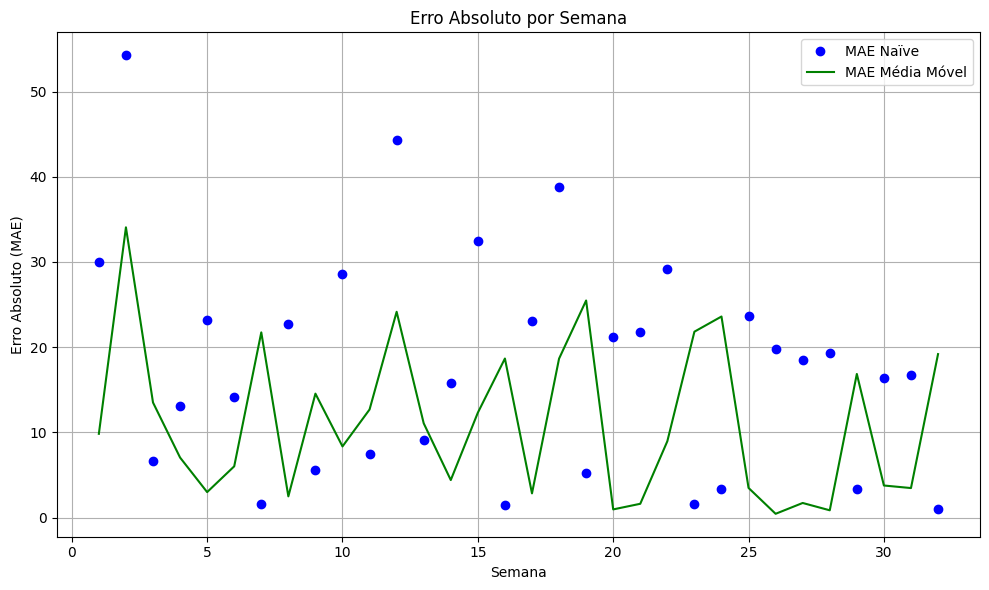

In [30]:
# Erro absoluto ao longo do tempo (ponto a ponto)
mae_naive_series = np.abs(test - naive_forecast)
mae_mavg_series = np.abs(test - moving_avg_forecast)

epochs = range(1, len(test) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, mae_naive_series, 'bo', label='MAE Naïve')  # pontos azuis
plt.plot(epochs, mae_mavg_series, 'g', label='MAE Média Móvel')  # linha verde
plt.title('Erro Absoluto por Semana')
plt.xlabel('Semana')
plt.ylabel('Erro Absoluto (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

densely connected

In [31]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Função para transformar série temporal em dados supervisionados
def create_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

# Definir janela e gerar os dados
window_size = 8  # semanas
X, y = create_dataset(sales_series.values, window_size)

# Separar treino e teste
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Normalização
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
y_train = (y_train - mean) / std
y_test = (y_test - mean) / std

# Modelo Keras com camadas densas
model = keras.Sequential([
    layers.Input(shape=(window_size,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Treinamento
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - loss: 1.2330 - mae: 0.8774 - val_loss: 2.0301 - val_mae: 1.1280
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0384 - mae: 0.7846 - val_loss: 1.9473 - val_mae: 1.1157
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0548 - mae: 0.8206 - val_loss: 1.8462 - val_mae: 1.0993
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7593 - mae: 0.6763 - val_loss: 1.7704 - val_mae: 1.0872
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8302 - mae: 0.7316 - val_loss: 1.7105 - val_mae: 1.0771
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7759 - mae: 0.7049 - val_loss: 1.7087 - val_mae: 1.0767
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7294 - mae: 0.6592 - val_loss: 1.6688 - val_mae: 1.0679
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8492 - mae: 0.7300 - val_loss: 1.6730 - val_mae: 1.0680
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6603 - mae:

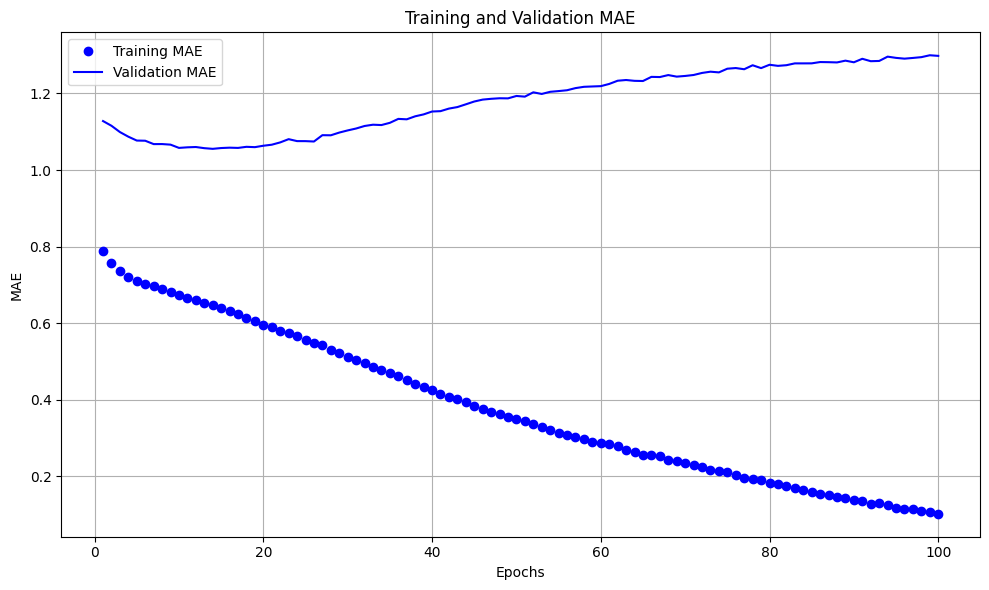

In [32]:
import matplotlib.pyplot as plt

loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label='Training MAE')
plt.plot(epochs, val_loss, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
